In [76]:
%%javascript
$.getScript("../../j_n_contents.js")

<IPython.core.display.Javascript object>

<div id="toc">
</div>

# 9.1 图像增广

In [47]:
import os
import time
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(device)

1.2.0
cuda


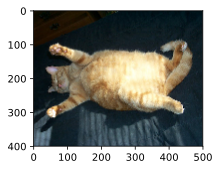

In [3]:
d2l.set_figsize()
img = Image.open('../../img/cat1.jpg')
d2l.plt.imshow(img)

In [4]:
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

In [5]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

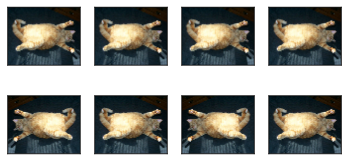

In [6]:
apply(img, torchvision.transforms.RandomHorizontalFlip())


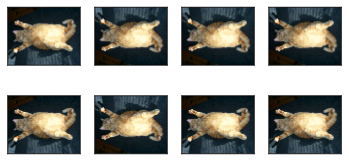

In [7]:
apply(img, torchvision.transforms.RandomVerticalFlip())


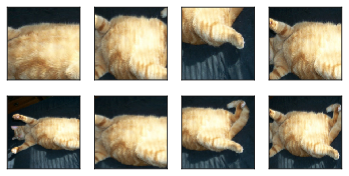

In [8]:
shape_aug = torchvision.transforms.RandomResizedCrop(200, scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)


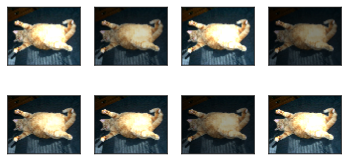

In [9]:
apply(img,torchvision.transforms.ColorJitter(brightness=0.5))

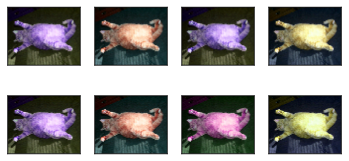

In [10]:
apply(img,torchvision.transforms.ColorJitter(hue=0.5))

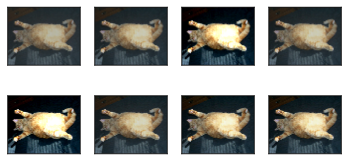

In [11]:
apply(img,torchvision.transforms.ColorJitter(contrast=0.5))

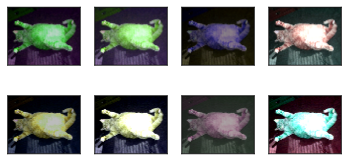

In [13]:
color_aug=torchvision.transforms.ColorJitter(hue=0.5,
                                            brightness=0.5,
                                            contrast=0.5,
                                            saturation=0.5)
apply(img,color_aug)


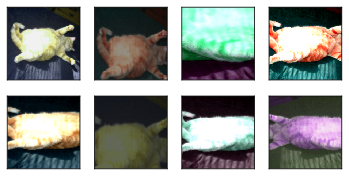

In [15]:
augs=torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),color_aug,shape_aug
])
apply(img,augs)

Files already downloaded and verified


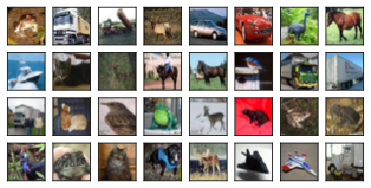

In [16]:
all_imges = torchvision.datasets.CIFAR10(train=True, root="~/Datasets/CIFAR", download=True)
# all_imges的每一个元素都是(image, label)
show_images([all_imges[i][0] for i in range(32)], 4, 8, scale=0.8);

In [17]:
flip_aug = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

no_aug = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [19]:
num_workers = 0 if sys.platform.startswith('win32') else 16
def load_cifar10(is_train, augs, batch_size, root="~/Datasets/CIFAR"):
    dataset = torchvision.datasets.CIFAR10(root=root, train=is_train, transform=augs, download=True)
    return DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

In [31]:
def train(train_iter,test_iter,net,loss,optimizer,device,num_epochs):
        net=net.to(device)
        print("trianing on ",device)
        batch_count=0
        for epoch in range(num_epochs):
            train_l_sum,train_acc_sum,n,start=0.0,0.0,0,time.time()
            for x,y in train_iter:
                x=x.to(device)
                y=y.to(device)
                y_hat=net(x)
                l=loss(y_hat,y)
                optimizer.zero_grad()
                l.backward()
                optimizer.step()
                train_l_sum += l.cpu().item()
                train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
                n += y.shape[0]
                batch_count += 1
            test_acc = d2l.evaluate_accuracy(test_iter, net)
            print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
                  % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

In [32]:
def train_with_data_aug(train_augs,test_augs,lr=0.001,device=torch.device("cuda")):
    batch_size,net=256,d2l.resnet18(10)
    optimizer=torch.optim.Adam(net.parameters(),lr=lr)
    loss=torch.nn.CrossEntropyLoss()
    train_iter=load_cifar10(True,train_augs,batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter,test_iter,net,loss,optimizer,device,num_epochs=10)

In [33]:
train_with_data_aug(flip_aug,no_aug)

Files already downloaded and verified
Files already downloaded and verified
trianing on  cuda
epoch 1, loss 1.3884, train acc 0.499, test acc 0.553, time 11.4 sec
epoch 2, loss 0.5034, train acc 0.642, test acc 0.592, time 11.7 sec
epoch 3, loss 0.2848, train acc 0.700, test acc 0.597, time 11.5 sec
epoch 4, loss 0.1887, train acc 0.736, test acc 0.644, time 11.3 sec
epoch 5, loss 0.1367, train acc 0.761, test acc 0.585, time 11.3 sec
epoch 6, loss 0.1032, train acc 0.785, test acc 0.603, time 11.5 sec
epoch 7, loss 0.0809, train acc 0.803, test acc 0.667, time 11.5 sec
epoch 8, loss 0.0648, train acc 0.819, test acc 0.720, time 11.7 sec
epoch 9, loss 0.0526, train acc 0.836, test acc 0.733, time 11.6 sec
epoch 10, loss 0.0438, train acc 0.848, test acc 0.745, time 11.6 sec


# 9.2 微调

In [1]:
%matplotlib inline
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import os

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
data_dir = '../Datasets/hotdog'
os.listdir(os.path.join(data_dir, "hotdog"))

['test', 'train']

In [3]:
train_imgs = ImageFolder(os.path.join(data_dir, 'hotdog/train'))
test_imgs = ImageFolder(os.path.join(data_dir, 'hotdog/test'))

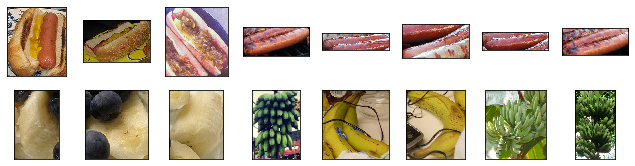

In [4]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_augs = transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

test_augs = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        normalize
    ])

In [6]:
pretrained_net = models.resnet18(pretrained=True)

In [7]:
print(pretrained_net.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [8]:
pretrained_net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
pretrained_net.fc=nn.Linear(512,2)
print(pretrained_net.fc)

Linear(in_features=512, out_features=2, bias=True)


In [10]:
output_params=list(map(id,pretrained_net.fc.parameters()))
feature_params=filter(lambda p:id(p) not in output_params, pretrained_net.parameters())
lr=0.01
optimizer=optim.SGD([
    {'params':feature_params},
    {'params':pretrained_net.fc.parameters(),'lr':lr*10}
],lr=lr,weight_decay=0.001)

In [11]:
def train_fine_tuning(net, optimizer, batch_size=128, num_epochs=5):
    train_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'hotdog/train'), transform=train_augs),
                            batch_size, shuffle=True)
    test_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'hotdog/test'), transform=test_augs),
                           batch_size)
    loss = torch.nn.CrossEntropyLoss()
    d2l.train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)

In [12]:
train_fine_tuning(pretrained_net, optimizer)

training on  cuda
epoch 1, loss 5.0368, train acc 0.632, test acc 0.896, time 22.4 sec
epoch 2, loss 0.1992, train acc 0.915, test acc 0.890, time 21.4 sec
epoch 3, loss 0.1210, train acc 0.913, test acc 0.934, time 21.5 sec
epoch 4, loss 0.0759, train acc 0.919, test acc 0.905, time 21.0 sec
epoch 5, loss 0.0440, train acc 0.935, test acc 0.939, time 19.5 sec


In [13]:
scratch_net = models.resnet18(pretrained=False, num_classes=2)
lr = 0.1
optimizer = optim.SGD(scratch_net.parameters(), lr=lr, weight_decay=0.001)
train_fine_tuning(scratch_net, optimizer)


training on  cuda
epoch 1, loss 2.5338, train acc 0.635, test acc 0.772, time 21.4 sec
epoch 2, loss 0.2288, train acc 0.796, test acc 0.834, time 20.9 sec
epoch 3, loss 0.1270, train acc 0.823, test acc 0.810, time 21.3 sec
epoch 4, loss 0.1183, train acc 0.804, test acc 0.571, time 21.2 sec
epoch 5, loss 0.0798, train acc 0.830, test acc 0.807, time 21.0 sec


# 9.3 目标检测和边界框

In [14]:
from PIL import Image
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l


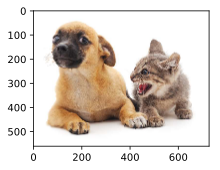

In [17]:
d2l.set_figsize()
img = Image.open('../../img/catdog.jpg')
d2l.plt.imshow(img);
 # 加分号只显示图


In [18]:
dog_bbox, cat_bbox = [60, 45, 378, 516], [400, 112, 655, 493]


In [19]:
def bbox_to_rect(bbox, color):  # 本函数已保存在d2lzh_pytorch中方便以后使用
    # 将边界框(左上x, 左上y, 右下x, 右下y)格式转换成matplotlib格式：
    # ((左上x, 左上y), 宽, 高)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

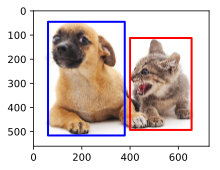

In [20]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));


# 9.4 锚框

In [2]:
from PIL import Image
import numpy as np
import math
import torch
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l
print(torch.__version__) # 1.2.0


1.2.0


In [3]:
d2l.set_figsize()
img=Image.open('../../img/catdog.jpg')
w,h=img.size
print(w,h)

728 561


In [9]:
def multiboxprior(feature_map,sizes=[0.75,0.5,0.25],ratios=[1,2,0.5]):
    pairs=[]
    for r in ratios:
        pairs.append([sizes[0],math.sqrt(r)])
    for s in sizes[1:]:
        pairs.append([s,math.sqrt(ratios[0])])
    pairs=np.array(pairs)
    
    ss1=pairs[:,0]*pairs[:,1]
    ss2=pairs[:,0]/pairs[:,1]
    
    base_anchors=np.stack([-ss1,-ss2,ss1,ss2],axis=1)/2
    
    h, w = feature_map.shape[-2:]
    shifts_x = np.arange(0, w) / w
    shifts_y = np.arange(0, h) / h
    shift_x, shift_y = np.meshgrid(shifts_x, shifts_y)
    shift_x = shift_x.reshape(-1)
    shift_y = shift_y.reshape(-1)
    shifts = np.stack((shift_x, shift_y, shift_x, shift_y), axis=1)
    
    anchors = shifts.reshape((-1, 1, 4)) + base_anchors.reshape((1, -1, 4))
    
    return torch.tensor(anchors, dtype=torch.float32).view(1, -1, 4)

In [11]:
X = torch.Tensor(1, 3, h, w)  # 构造输入数据
y = multiboxprior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
y.shape

torch.Size([1, 2042040, 4])

In [13]:
boxes=y.reshape((h,w,5,4))
boxes[250,250,0,:]

tensor([-0.0316,  0.0706,  0.7184,  0.8206])

In [15]:
# 本函数已保存在dd2lzh_pytorch包中方便以后使用
def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().cpu().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=6, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

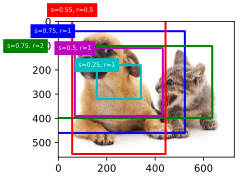

In [16]:
d2l.set_figsize()
fig = d2l.plt.imshow(img)
bbox_scale = torch.tensor([[w, h, w, h]], dtype=torch.float32)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.75, r=2', 's=0.55, r=0.5', 's=0.5, r=1', 's=0.25, r=1'])

In [17]:
# 以下函数已保存在d2lzh_pytorch包中方便以后使用
def compute_intersection(set_1, set_2):
    """
    计算anchor之间的交集
    Args:
        set_1: a tensor of dimensions (n1, 4), anchor表示成(xmin, ymin, xmax, ymax)
        set_2: a tensor of dimensions (n2, 4), anchor表示成(xmin, ymin, xmax, ymax)
    Returns:
        intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, shape: (n1, n2)
    """
    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def compute_jaccard(set_1, set_2):
    """
    计算anchor之间的Jaccard系数(IoU)
    Args:
        set_1: a tensor of dimensions (n1, 4), anchor表示成(xmin, ymin, xmax, ymax)
        set_2: a tensor of dimensions (n2, 4), anchor表示成(xmin, ymin, xmax, ymax)
    Returns:
        Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, shape: (n1, n2)
    """
    # Find intersections
    intersection = compute_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

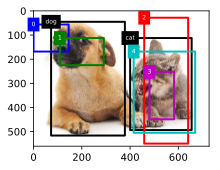

In [18]:
bbox_scale = torch.tensor((w, h, w, h), dtype=torch.float32)
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                            [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [19]:
compute_jaccard(anchors, ground_truth[:, 1:]) # 验证一下写的compute_jaccard函数

tensor([[0.0536, 0.0000],
        [0.1417, 0.0000],
        [0.0000, 0.5657],
        [0.0000, 0.2059],
        [0.0000, 0.7459]])

In [21]:
# 以下函数已保存在d2lzh_pytorch包中方便以后使用
def assign_anchor(bb, anchor, jaccard_threshold=0.5):
    """
    # 按照「9.4.1. 生成多个锚框」图9.3所讲为每个anchor分配真实的bb, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        bb: 真实边界框(bounding box), shape:（nb, 4）
        anchor: 待分配的anchor, shape:（na, 4）
        jaccard_threshold: 预先设定的阈值
    Returns:
        assigned_idx: shape: (na, ), 每个anchor分配的真实bb对应的索引, 若未分配任何bb则为-1
    """
    na = anchor.shape[0]
    nb = bb.shape[0]
    jaccard = compute_jaccard(anchor, bb).detach().cpu().numpy() # shape: (na, nb)
    assigned_idx = np.ones(na) * -1  # 初始全为-1
    
    # 先为每个bb分配一个anchor(不要求满足jaccard_threshold)
    jaccard_cp = jaccard.copy()
    for j in range(nb):
        i = np.argmax(jaccard_cp[:, j])
        assigned_idx[i] = j
        jaccard_cp[i, :] = float("-inf") # 赋值为负无穷, 相当于去掉这一行
     
    # 处理还未被分配的anchor, 要求满足jaccard_threshold
    for i in range(na):
        if assigned_idx[i] == -1:
            j = np.argmax(jaccard[i, :])
            if jaccard[i, j] >= jaccard_threshold:
                assigned_idx[i] = j
    
    return torch.tensor(assigned_idx, dtype=torch.long)


def xy_to_cxcy(xy):
    """
    将(x_min, y_min, x_max, y_max)形式的anchor转换成(center_x, center_y, w, h)形式的.
    https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py
    Args:
        xy: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    Returns: 
        bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h

def MultiBoxTarget(anchor, label):
    """
    # 按照「9.4.1. 生成多个锚框」所讲的实现, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        anchor: torch tensor, 输入的锚框, 一般是通过MultiBoxPrior生成, shape:（1，锚框总数，4）
        label: 真实标签, shape为(bn, 每张图片最多的真实锚框数, 5)
               第二维中，如果给定图片没有这么多锚框, 可以先用-1填充空白, 最后一维中的元素为[类别标签, 四个坐标值]
    Returns:
        列表, [bbox_offset, bbox_mask, cls_labels]
        bbox_offset: 每个锚框的标注偏移量，形状为(bn，锚框总数*4)
        bbox_mask: 形状同bbox_offset, 每个锚框的掩码, 一一对应上面的偏移量, 负类锚框(背景)对应的掩码均为0, 正类锚框的掩码均为1
        cls_labels: 每个锚框的标注类别, 其中0表示为背景, 形状为(bn，锚框总数)
    """
    assert len(anchor.shape) == 3 and len(label.shape) == 3
    bn = label.shape[0]
    
    def MultiBoxTarget_one(anc, lab, eps=1e-6):
        """
        MultiBoxTarget函数的辅助函数, 处理batch中的一个
        Args:
            anc: shape of (锚框总数, 4)
            lab: shape of (真实锚框数, 5), 5代表[类别标签, 四个坐标值]
            eps: 一个极小值, 防止log0
        Returns:
            offset: (锚框总数*4, )
            bbox_mask: (锚框总数*4, ), 0代表背景, 1代表非背景
            cls_labels: (锚框总数, 4), 0代表背景
        """
        an = anc.shape[0]
        assigned_idx = assign_anchor(lab[:, 1:], anc) # (锚框总数, )
        bbox_mask = ((assigned_idx >= 0).float().unsqueeze(-1)).repeat(1, 4) # (锚框总数, 4)

        cls_labels = torch.zeros(an, dtype=torch.long) # 0表示背景
        assigned_bb = torch.zeros((an, 4), dtype=torch.float32) # 所有anchor对应的bb坐标
        for i in range(an):
            bb_idx = assigned_idx[i]
            if bb_idx >= 0: # 即非背景
                cls_labels[i] = lab[bb_idx, 0].long().item() + 1 # 注意要加一
                assigned_bb[i, :] = lab[bb_idx, 1:]

        center_anc = xy_to_cxcy(anc) # (center_x, center_y, w, h)
        center_assigned_bb = xy_to_cxcy(assigned_bb)

        offset_xy = 10.0 * (center_assigned_bb[:, :2] - center_anc[:, :2]) / center_anc[:, 2:]
        offset_wh = 5.0 * torch.log(eps + center_assigned_bb[:, 2:] / center_anc[:, 2:])
        offset = torch.cat([offset_xy, offset_wh], dim = 1) * bbox_mask # (锚框总数, 4)

        return offset.view(-1), bbox_mask.view(-1), cls_labels
    
    batch_offset = []
    batch_mask = []
    batch_cls_labels = []
    for b in range(bn):
        offset, bbox_mask, cls_labels = MultiBoxTarget_one(anchor[0, :, :], label[b, :, :])
        
        batch_offset.append(offset)
        batch_mask.append(bbox_mask)
        batch_cls_labels.append(cls_labels)
    
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    cls_labels = torch.stack(batch_cls_labels)
    
    return [bbox_offset, bbox_mask, cls_labels]

In [22]:
labels = MultiBoxTarget(anchors.unsqueeze(dim=0),
                        ground_truth.unsqueeze(dim=0))

In [23]:
labels[2]

tensor([[0, 1, 2, 0, 2]])

In [24]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

In [25]:
labels[0]

tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,  1.4000e+00,
          1.0000e+01,  2.5940e+00,  7.1754e+00, -1.2000e+00,  2.6882e-01,
          1.6824e+00, -1.5655e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -5.7143e-01, -1.0000e+00,  4.1723e-06,  6.2582e-01]])

In [26]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                        [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0.0] * (4 * len(anchors)))
cls_probs = torch.tensor([[0., 0., 0., 0.,],  # 背景的预测概率
                          [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                          [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

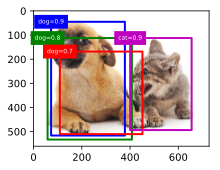

In [27]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [28]:
# 以下函数已保存在d2lzh_pytorch包中方便以后使用
from collections import namedtuple
Pred_BB_Info = namedtuple("Pred_BB_Info", ["index", "class_id", "confidence", "xyxy"])

def non_max_suppression(bb_info_list, nms_threshold = 0.5):
    """
    非极大抑制处理预测的边界框
    Args:
        bb_info_list: Pred_BB_Info的列表, 包含预测类别、置信度等信息
        nms_threshold: 阈值
    Returns:
        output: Pred_BB_Info的列表, 只保留过滤后的边界框信息
    """
    output = []
    # 先根据置信度从高到低排序
    sorted_bb_info_list = sorted(bb_info_list, key = lambda x: x.confidence, reverse=True)

    while len(sorted_bb_info_list) != 0:
        best = sorted_bb_info_list.pop(0)
        output.append(best)
        
        if len(sorted_bb_info_list) == 0:
            break

        bb_xyxy = []
        for bb in sorted_bb_info_list:
            bb_xyxy.append(bb.xyxy)
        
        iou = compute_jaccard(torch.tensor([best.xyxy]), 
                              torch.tensor(bb_xyxy))[0] # shape: (len(sorted_bb_info_list), )
        
        n = len(sorted_bb_info_list)
        sorted_bb_info_list = [sorted_bb_info_list[i] for i in range(n) if iou[i] <= nms_threshold]
    return output

def MultiBoxDetection(cls_prob, loc_pred, anchor, nms_threshold = 0.5):
    """
    # 按照「9.4.1. 生成多个锚框」所讲的实现, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        cls_prob: 经过softmax后得到的各个锚框的预测概率, shape:(bn, 预测总类别数+1, 锚框个数)
        loc_pred: 预测的各个锚框的偏移量, shape:(bn, 锚框个数*4)
        anchor: MultiBoxPrior输出的默认锚框, shape: (1, 锚框个数, 4)
        nms_threshold: 非极大抑制中的阈值
    Returns:
        所有锚框的信息, shape: (bn, 锚框个数, 6)
        每个锚框信息由[class_id, confidence, xmin, ymin, xmax, ymax]表示
        class_id=-1 表示背景或在非极大值抑制中被移除了
    """
    assert len(cls_prob.shape) == 3 and len(loc_pred.shape) == 2 and len(anchor.shape) == 3
    bn = cls_prob.shape[0]
    
    def MultiBoxDetection_one(c_p, l_p, anc, nms_threshold = 0.5):
        """
        MultiBoxDetection的辅助函数, 处理batch中的一个
        Args:
            c_p: (预测总类别数+1, 锚框个数)
            l_p: (锚框个数*4, )
            anc: (锚框个数, 4)
            nms_threshold: 非极大抑制中的阈值
        Return:
            output: (锚框个数, 6)
        """
        pred_bb_num = c_p.shape[1]
        anc = (anc + l_p.view(pred_bb_num, 4)).detach().cpu().numpy() # 加上偏移量
        
        confidence, class_id = torch.max(c_p, 0)
        confidence = confidence.detach().cpu().numpy()
        class_id = class_id.detach().cpu().numpy()
        
        pred_bb_info = [Pred_BB_Info(
                            index = i,
                            class_id = class_id[i] - 1, # 正类label从0开始
                            confidence = confidence[i],
                            xyxy=[*anc[i]]) # xyxy是个列表
                        for i in range(pred_bb_num)]
        
        # 正类的index
        obj_bb_idx = [bb.index for bb in non_max_suppression(pred_bb_info, nms_threshold)]
        
        output = []
        for bb in pred_bb_info:
            output.append([
                (bb.class_id if bb.index in obj_bb_idx else -1.0),
                bb.confidence,
                *bb.xyxy
            ])
            
        return torch.tensor(output) # shape: (锚框个数, 6)
    
    batch_output = []
    for b in range(bn):
        batch_output.append(MultiBoxDetection_one(cls_prob[b], loc_pred[b], anchor[0], nms_threshold))
    
    return torch.stack(batch_output)

In [29]:
output = MultiBoxDetection(
    cls_probs.unsqueeze(dim=0), offset_preds.unsqueeze(dim=0),
    anchors.unsqueeze(dim=0), nms_threshold=0.5)
output

tensor([[[ 0.0000,  0.9000,  0.1000,  0.0800,  0.5200,  0.9200],
         [-1.0000,  0.8000,  0.0800,  0.2000,  0.5600,  0.9500],
         [-1.0000,  0.7000,  0.1500,  0.3000,  0.6200,  0.9100],
         [ 1.0000,  0.9000,  0.5500,  0.2000,  0.9000,  0.8800]]])

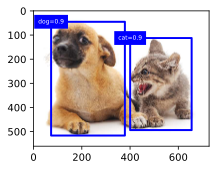

In [30]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().cpu().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

# 9.5 多尺度目标检测

In [3]:
from PIL import Image
import numpy as np
import torch
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l
img=Image.open("../../img/catdog.jpg")
w,h=img.size

In [4]:
w,h

(728, 561)

In [5]:
d2l.set_figsize()

def display_anchors(fmap_w, fmap_h, s):
    # 前两维的取值不影响输出结果(原书这里是(1, 10, fmap_w, fmap_h), 我认为错了)
    fmap = torch.zeros((1, 10, fmap_h, fmap_w), dtype=torch.float32)
    
    # 平移所有锚框使均匀分布在图片上
    offset_x, offset_y = 1.0/fmap_w, 1.0/fmap_h
    anchors = d2l.MultiBoxPrior(fmap, sizes=s, ratios=[1, 2, 0.5]) + \
        torch.tensor([offset_x/2, offset_y/2, offset_x/2, offset_y/2])
    
    bbox_scale = torch.tensor([[w, h, w, h]], dtype=torch.float32)
    d2l.show_bboxes(d2l.plt.imshow(img).axes,
                    anchors[0] * bbox_scale)

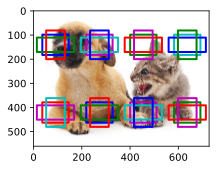

In [6]:
display_anchors(fmap_w=4, fmap_h=2, s=[0.15])


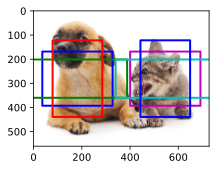

In [7]:
display_anchors(fmap_w=2, fmap_h=1, s=[0.4])


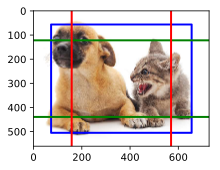

In [10]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])


# 9.6 目标检测数据集(皮卡丘)

In [14]:
%matplotlib inline
import os
import json
import numpy as np
import torch
import torchvision
from PIL import Image

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l
print(torch.__version__)

data_dir = '../../data/pikachu'

1.2.0


In [15]:
assert os.path.exists(os.path.join(data_dir, "train"))

In [16]:
# 本类已保存在d2lzh_pytorch包中方便以后使用
class PikachuDetDataset(torch.utils.data.Dataset):
    """皮卡丘检测数据集类"""
    def __init__(self, data_dir, part, image_size=(256, 256)):
        assert part in ["train", "val"]
        self.image_size = image_size
        self.image_dir = os.path.join(data_dir, part, "images")
        
        with open(os.path.join(data_dir, part, "label.json")) as f:
            self.label = json.load(f)
            
        self.transform = torchvision.transforms.Compose([
            # 将 PIL 图片转换成位于[0.0, 1.0]的floatTensor, shape (C x H x W)
            torchvision.transforms.ToTensor()])
            
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, index):
        image_path = str(index + 1) + ".png"
        
        cls = self.label[image_path]["class"]
        label = np.array([cls] + self.label[image_path]["loc"], 
                         dtype="float32")[None, :]
        
        PIL_img = Image.open(os.path.join(self.image_dir, image_path)
                            ).convert('RGB').resize(self.image_size)
        img = self.transform(PIL_img)
        
        sample = {
            "label": label, # shape: (1, 5) [class, xmin, ymin, xmax, ymax]
            "image": img    # shape: (3, *image_size)
        }
        
        return sample
    

# 本函数已保存在d2lzh_pytorch包中方便以后使用
def load_data_pikachu(batch_size, edge_size=256, data_dir = '../../data/pikachu'):  
    """edge_size：输出图像的宽和高"""
    image_size = (edge_size, edge_size)
    train_dataset = PikachuDetDataset(data_dir, 'train', image_size)
    val_dataset = PikachuDetDataset(data_dir, 'val', image_size)
    

    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                             shuffle=True, num_workers=4)

    val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                           shuffle=False, num_workers=4)
    return train_iter, val_iter

In [17]:
batch_size, edge_size = 32, 256

train_iter, _ = load_data_pikachu(batch_size, edge_size, data_dir)
batch = iter(train_iter).next()

print(batch["image"].shape, batch["label"].shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 5])


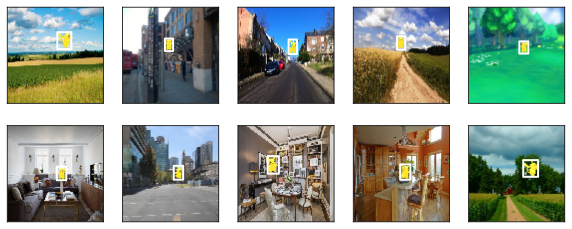

In [18]:
imgs = batch["image"][0:10].permute(0,2,3,1)
bboxes = batch["label"][0:10, 0, 1:]

axes = d2l.show_images(imgs, 2, 5).flatten()
for ax, bb in zip(axes, bboxes):
    d2l.show_bboxes(ax, [bb*edge_size], colors=['w'])

# 9.8 区域卷积神经网络(R-CNN) 系列

## RCNN

RCNN 主要由下面四部构成:
1. 对输入图像进行选择性搜索来选取多个高质量的区域,这些区域通常是在所个尺度下选取的,并具有不同的形状和大小.每个区域将标注类别和真实边界框.
2. 选取一个预训练的卷积神经网络,并将其在输出层之前截断,将每个提议区域变形为网络需要的输入尺寸,并通过前向计算输出抽取的区域特征
3. 将每个区域的特征联通类别作为一个样本,训练多个支持向量机,每个向量机独立判定某一类别.
4. 对每个区域特征联通边框的样本,训练线性回归模型来预测真实边界框


- 但对于某个图像来说,每次训练的数据太大,因此不能广泛采用

## Fast RCNN

RCNN 计算量大的一个主要原因就是每次对区域进行抽取特征的时候,区域通常有大量的重复,因此这个过程有大量的吃哦功夫计算,Fast RCNN 的一个主要改进在于对整个图像做卷积神经网络的前向计算. 其主要的步骤如下:

1. 提取整个图像作为输入,先经过一个卷积
2. 经过兴趣池化层,无论前面输出是啥,经过固定的划分池化,第二步后输出形状一致
3. 经过全链接层,分别链接类别预测/框预测.

In [32]:
import torch
import torchvision
print(torchvision.__version__)

0.2.1


In [33]:
X = torch.arange(16, dtype=torch.float).view(1, 1, 4, 4)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [34]:
rois = torch.tensor([[0, 0, 0, 20, 20], [0, 0, 10, 30, 30]], dtype=torch.float)

In [35]:
torchvision.ops.roi_pool(X, rois, output_size=(2, 2), spatial_scale=0.1)

AttributeError: module 'torchvision' has no attribute 'ops'

## Faster RCNN


Fast RCNN 需要在选择性搜索中生成较多的区域以获得较精确的检测结果, 而Faster RCNN 将其替换为区域提议网络,从而减少区域生成的数量,并保证目标检测的精度,
具体来说:
1. 使用填充为1 的3*3 卷积层变换卷积神经网络的输出,并将输出通道数记为c. 这样,卷积神经网络为图像抽取的特征图中的每个单元均得到一个长度为c的新特征.
2. 以特征图每个单元为中心, 生成多个不同大小和宽高比的锚框并标注它们.
3. 用锚框中心单元长度为c的特征分别预测该锚框的二元类别.
4. 用非极大值抑制,从预测类别为目标的预测边界框中移除相似结果,最终输出边界框即兴趣区域池化层所需要的提议区域

Faster RCNN 的目标函数包括目标检测类别,边界框预测,区域提议网络中锚框二元类别和边界框预测

## Mask RCNN

将Faster RCNN 的兴趣区域池化层替换为了兴趣区域对齐层,即通过双线性插值来保留特征图上的空间信息,从而更适于像素级预测

# 9.9 语义分割和数据集

In [37]:
%matplotlib inline
import time
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from PIL import Image
from tqdm import tqdm

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

print(torch.__version__, torchvision.__version__)

1.2.0 0.2.1


In [38]:
# 本函数已保存在d2lzh_pytorch中方便以后使用
def read_voc_images(root="../../data/voc/VOCdevkit/VOC2012", 
                    is_train=True, max_num=None):
    txt_fname = '%s/ImageSets/Segmentation/%s' % (
        root, 'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    if max_num is not None:
        images = images[:min(max_num, len(images))]
    features, labels = [None] * len(images), [None] * len(images)
    for i, fname in tqdm(enumerate(images)):
        features[i] = Image.open('%s/JPEGImages/%s.jpg' % (root, fname)).convert("RGB")
        labels[i] = Image.open('%s/SegmentationClass/%s.png' % (root, fname)).convert("RGB")
    return features, labels # PIL image

In [39]:
voc_dir = "../../data/voc/VOCdevkit/VOC2012"
train_features, train_labels = read_voc_images(voc_dir, max_num=100)

100it [00:00, 165.59it/s]


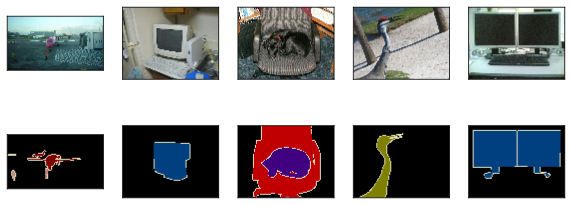

In [40]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
d2l.show_images(imgs, 2, n);

In [41]:
# 本函数已保存在d2lzh_pytorch中方便以后使用
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
# 本函数已保存在d2lzh_pytorch中方便以后使用
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [42]:
colormap2label = torch.zeros(256 ** 3, dtype=torch.uint8)
for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

# 本函数已保存在d2lzh_pytorch中方便以后使用
def voc_label_indices(colormap, colormap2label):
    """
    convert colormap (PIL image) to colormap2label (uint8 tensor).
    """
    colormap = np.array(colormap.convert("RGB")).astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

In [43]:
y = voc_label_indices(train_labels[0], colormap2label)
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]], dtype=torch.uint8), 'aeroplane')

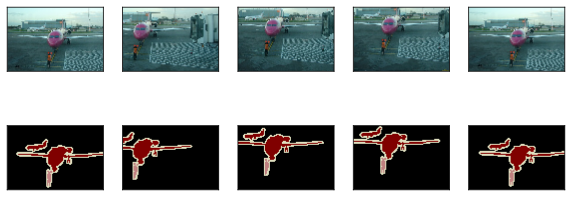

In [44]:
# 本函数已保存在d2lzh_pytorch中方便以后使用
def voc_rand_crop(feature, label, height, width):
    """
    Random crop feature (PIL image) and label (PIL image).
    """
    i, j, h, w = torchvision.transforms.RandomCrop.get_params(
            feature, output_size=(height, width))
    
    feature = torchvision.transforms.functional.crop(feature, i, j, h, w)
    label = torchvision.transforms.functional.crop(label, i, j, h, w)    

    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

In [45]:
# 本函数已保存在d2lzh_pytorch中方便以后使用
class VOCSegDataset(torch.utils.data.Dataset):
    def __init__(self, is_train, crop_size, voc_dir, colormap2label, max_num=None):
        """
        crop_size: (h, w)
        """
        self.rgb_mean = np.array([0.485, 0.456, 0.406])
        self.rgb_std = np.array([0.229, 0.224, 0.225])
        self.tsf = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=self.rgb_mean, 
                                             std=self.rgb_std)
        ])
        
        self.crop_size = crop_size # (h, w)
        features, labels = read_voc_images(root=voc_dir, 
                                           is_train=is_train, 
                                           max_num=max_num)
        self.features = self.filter(features) # PIL image
        self.labels = self.filter(labels)     # PIL image
        self.colormap2label = colormap2label
        print('read ' + str(len(self.features)) + ' valid examples')

    def filter(self, imgs):
        return [img for img in imgs if (
            img.size[1] >= self.crop_size[0] and
            img.size[0] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        
        return (self.tsf(feature),
                voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

In [46]:
crop_size = (320, 480)
max_num = 100
voc_train = VOCSegDataset(True, crop_size, voc_dir, colormap2label, max_num)
voc_test = VOCSegDataset(False, crop_size, voc_dir, colormap2label, max_num)

100it [00:00, 166.74it/s]
16it [00:00, 150.66it/s]

read 75 valid examples


100it [00:00, 144.93it/s]

read 77 valid examples


In [47]:
batch_size = 64
num_workers = 0 if sys.platform.startswith('win32') else 4
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                              drop_last=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(voc_test, batch_size, drop_last=True,
                             num_workers=num_workers)

In [48]:
for X, Y in train_iter:
    print(X.dtype, X.shape)
    print(y.dtype, Y.shape)
    break

torch.float32 torch.Size([64, 3, 320, 480])
torch.uint8 torch.Size([64, 320, 480])


# 9.11 样式迁移

In [87]:
%matplotlib inline
import time
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from PIL import Image

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 均已测试
device = torch.device('cpu')
print(device, torch.__version__)

cpu 1.2.0


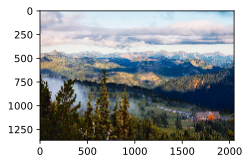

In [88]:
d2l.set_figsize()
content_img = Image.open('../../data/rainier.jpg')
d2l.plt.imshow(content_img);

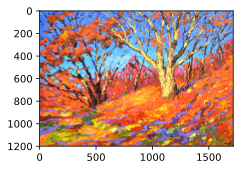

In [108]:
d2l.set_figsize()
style_img = Image.open('../../data/autumn_oak.jpg')
d2l.plt.imshow(style_img);

In [109]:
rgb_mean = np.array([0.485, 0.456, 0.406])
rgb_std = np.array([0.229, 0.224, 0.225])

def preprocess(PIL_img, image_shape):
    process = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])

    return process(PIL_img).unsqueeze(dim = 0) # (batch_size, 3, H, W)

def postprocess(img_tensor):
    inv_normalize = torchvision.transforms.Normalize(
        mean= -rgb_mean / rgb_std,
        std= 1/rgb_std)
    to_PIL_image = torchvision.transforms.ToPILImage()
    return to_PIL_image(inv_normalize(img_tensor[0].cpu()).clamp(0, 1))

In [110]:
!echo $TORCH_HOME # 将会把预训练好的模型下载到此处(没有输出的话默认是.cache/torch)
pretrained_net = torchvision.models.vgg19(pretrained=True)

In [111]:
pretrained_net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

- 每个卷积块的第一个卷积层作为样式层,第四卷积块的最后一个卷积层作为内容层

In [112]:
style_layers,content_layers=[0,5,10,19,28],[25]

In [113]:
net_list = []
for i in range(max(content_layers + style_layers) + 1):
    net_list.append(pretrained_net.features[i])
net = torch.nn.Sequential(*net_list)

In [114]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [133]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

In [134]:
def content_loss(Y_hat, Y):
    return F.mse_loss(Y_hat, Y)

将extract_features函数的输出c(通道数)*h*w转换为c个长度为hw的向量x1...xc, 并得到Gram matrix: $xx^T$, 其矩阵上的i行j列代表的是通道i与通道j的相关性

In [135]:
def gram(X):
    num_channels, n = X.shape[1], X.shape[2] * X.shape[3]
    X = X.view(num_channels, n)
    return torch.matmul(X, X.t()) / (num_channels * n)

In [118]:
def style_loss(Y_hat, gram_Y):
    return F.mse_loss(gram(Y_hat), gram_Y)

In [119]:
#使合成图像的像素值尽量接近原图像
def tv_loss(Y_hat):
    return 0.5 * (F.l1_loss(Y_hat[:, :, 1:, :], Y_hat[:, :, :-1, :]) + 
                  F.l1_loss(Y_hat[:, :, :, 1:], Y_hat[:, :, :, :-1]))

In [137]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、样式损失和总变差损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(styles_l) + sum(contents_l) + tv_l
    return contents_l, styles_l, tv_l, l

In [138]:
class GeneratedImage(torch.nn.Module):
    def __init__(self, img_shape):
        super(GeneratedImage, self).__init__()
        self.weight = torch.nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [139]:
def get_inits(X, device, lr, styles_Y):
    gen_img = GeneratedImage(X.shape).to(device)
    gen_img.weight.data = X.data
    optimizer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, optimizer

In [140]:
def train(X, contents_Y, styles_Y, device, lr, max_epochs, lr_decay_epoch):
    print("training on ", device)
    X, styles_Y_gram, optimizer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_decay_epoch, gamma=0.1)
    for i in range(max_epochs):
        start = time.time()
        
        contents_Y_hat, styles_Y_hat = extract_features(
                X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
                X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        
        optimizer.zero_grad()
        l.backward(retain_graph = True)
        optimizer.step()
        scheduler.step()
        
        if i % 50 == 0 and i != 0:
            print('epoch %3d, content loss %.2f, style loss %.2f, '
                  'TV loss %.2f, %.2f sec'
                  % (i, sum(contents_l).item(), sum(styles_l).item(), tv_l.item(),
                     time.time() - start))
    return X.detach()

In [141]:
image_shape =  (150, 225)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
style_X, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.01, 500, 200)

training on  cpu
epoch  50, content loss 0.01, style loss 0.07, TV loss 1.86, 1.78 sec
epoch 100, content loss 0.02, style loss 0.12, TV loss 1.45, 2.03 sec
epoch 150, content loss 0.02, style loss 0.14, TV loss 1.27, 2.18 sec
epoch 200, content loss 0.02, style loss 0.15, TV loss 1.18, 0.85 sec
epoch 250, content loss 0.02, style loss 0.15, TV loss 1.17, 1.45 sec
epoch 300, content loss 0.02, style loss 0.15, TV loss 1.16, 1.94 sec
epoch 350, content loss 0.02, style loss 0.15, TV loss 1.15, 1.90 sec
epoch 400, content loss 0.02, style loss 0.16, TV loss 1.15, 1.50 sec
epoch 450, content loss 0.02, style loss 0.16, TV loss 1.14, 1.39 sec


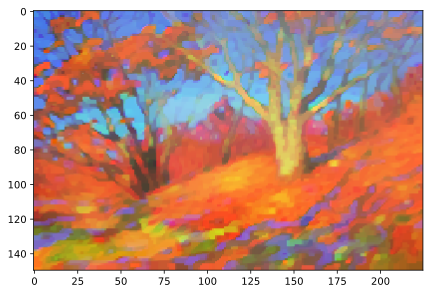

In [142]:
d2l.plt.imshow(postprocess(output));

In [130]:
image_shape = (300, 450)
_, content_Y = get_contents(image_shape, device)
_, style_Y = get_styles(image_shape, device)
X = preprocess(postprocess(output), image_shape).to(device)
big_output = train(X, content_Y, style_Y, device, 0.01, 500, 200)

training on  cpu
epoch  50, content loss 0.25, style loss 1.67, TV loss 0.50, 3.82 sec
epoch 100, content loss 0.17, style loss 0.88, TV loss 0.71, 3.49 sec
epoch 150, content loss 0.14, style loss 0.60, TV loss 0.75, 3.21 sec
epoch 200, content loss 0.13, style loss 0.47, TV loss 0.76, 3.35 sec
epoch 250, content loss 0.12, style loss 0.47, TV loss 0.76, 3.35 sec
epoch 300, content loss 0.12, style loss 0.46, TV loss 0.76, 3.44 sec
epoch 350, content loss 0.12, style loss 0.45, TV loss 0.76, 3.12 sec
epoch 400, content loss 0.12, style loss 0.44, TV loss 0.75, 3.97 sec
epoch 450, content loss 0.12, style loss 0.44, TV loss 0.75, 3.81 sec


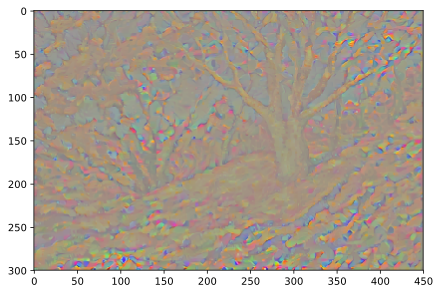

In [131]:
d2l.set_figsize((7, 5))
d2l.plt.imshow(postprocess(big_output));

In [132]:
print("ds")

ds
